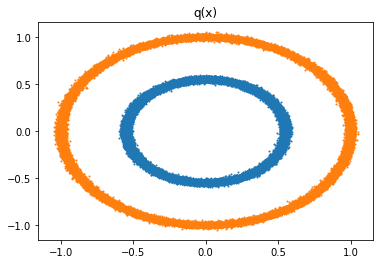

In [5]:
import torch
import torch.nn.functional as nn
import torch.nn.init as init
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):


        self.n_data = n_data
        self.radius = 2.0
        n_half_data = n_data//2
        data1 = np.random.randn(n_half_data, 2) * 0.03
        rand_theta = np.random.rand(n_half_data) * 2.0 * np.pi
        data1[:, 0] += np.cos(rand_theta) * 1.1
        data1[:, 1] += np.sin(rand_theta) * 1.1
        label1 = np.ones(n_half_data, np.int)

        data2 = np.random.randn(n_half_data, 2) * 0.03
        rand_theta = np.random.rand(n_half_data) * 2.0 * np.pi
        data2[:, 0] += np.cos(rand_theta) * 2.0
        data2[:, 1] += np.sin(rand_theta) * 2.0
        label2 = np.zeros(n_half_data, np.int)
        
    


        self.data = torch.from_numpy(np.concatenate([data1, data2])).float() * 0.5
        self.label = torch.from_numpy(np.concatenate([label1, label2])).float()
 

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



data_size = 80000
dataset = CustomDataSet(n_data=data_size)

data_points = dataset.data.data.numpy()
inner_point = []
outer_point = []
for i in range(dataset.n_data):
    if dataset.label[i] == 1:
        inner_point.append(data_points[i])
    else:
        outer_point.append(data_points[i])


inner_point = np.array(inner_point, np.float)
outer_point = np.array(outer_point, np.float)
plt.title('q(x)')
plt.scatter(inner_point[:, 0], inner_point[:, 1], s=1)
plt.scatter(outer_point[:, 0], outer_point[:, 1], s=1)
plt.show()
device = 'cpu'

In [12]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.LeakyReLU(0.001),
            torch.nn.Linear(16, 8),
            torch.nn.LeakyReLU(0.001),
            torch.nn.Linear(8, 16),
            torch.nn.LeakyReLU(0.001),
            torch.nn.Linear(16, 16),
            torch.nn.LeakyReLU(0.001),
            torch.nn.Linear(16, 2)
        ).to(device)

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        return self.net(x)


class Generator(torch.nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim, 16), 
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(True),
            torch.nn.Linear(16, 2)
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        return self.net(x)



def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [13]:
mb_size = 64
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)


X_DIM = 2
Z_DIM = 2
discriminator = Discriminator()
generator = Generator(Z_DIM)
d_solver = optim.Adam(discriminator.parameters(), lr=1e-4)
g_solver = optim.Adam(generator.parameters(), lr=1e-4)
ones = torch.ones(mb_size, 1).to(device)
zeros = torch.zeros(mb_size, 1).to(device)

In [74]:
num_epochs = 1
D_REAL = []
D_FAKE = []
m = 0.01
for epoch in range(num_epochs):
    D_REAL_AVG = 0.0
    D_FAKE_AVG = 0.0
    for _, X in enumerate(loader):
        X = X.to(device)


        g_solver.zero_grad()
        fake = generator(torch.randn(mb_size, Z_DIM).to(device))
        fake_recon = discriminator(fake)
        fake_energy = torch.mean((fake - fake_recon)**2) * X_DIM
        fake_energy.backward()        
        g_solver.step()



        d_solver.zero_grad()
        real_recon = discriminator(X)
        real_energy = torch.mean((X - real_recon)**2) * X_DIM
        fake = generator(torch.randn(mb_size, Z_DIM).to(device))
        fake_recon = discriminator(fake)

        fake_energy = torch.sum((fake - fake_recon)**2, dim=-1)
        adversarial_energy = torch.mean(nn.relu(m - fake_energy))
        (real_energy + adversarial_energy).backward()
        d_solver.step()

        D_REAL_AVG += torch.mean(real_energy).detach().item()
        D_FAKE_AVG += torch.mean(fake_energy).detach().item()

    D_REAL_AVG /= len(loader)
    D_FAKE_AVG /= len(loader)
    print(D_REAL_AVG, D_FAKE_AVG)

    D_REAL.append(D_REAL_AVG)
    D_FAKE.append(D_FAKE_AVG)


0.004357271612063051 0.004943835278600454


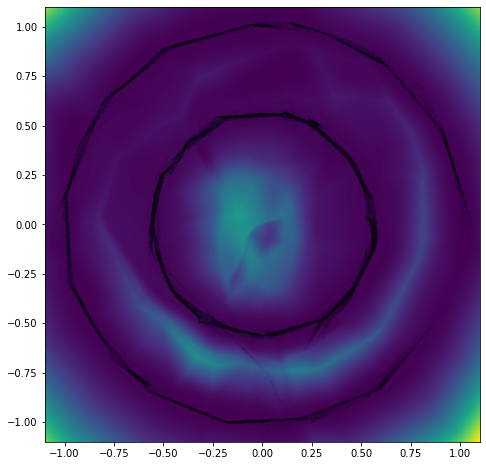

In [73]:
resol = 200
left_point = -1.1
right_point = 1.1
offset = (right_point - (left_point))/resol 

p = np.ones((resol, resol), np.float64)


x_region = torch.zeros((resol, resol, 2), dtype=torch.float)
for a_step in range(resol):
    for b_step in range(resol):
        x_region.data[a_step][b_step][0] = left_point + offset * (a_step)
        x_region.data[a_step][b_step][1] = left_point + offset * (b_step)



x = x_region.reshape(-1, 2)
x_recon = discriminator(x)
energy = (x - x_recon)**2
energy = energy.reshape(resol, resol, 2)
energy = torch.sum(energy, dim=-1)
for a_step in range(resol):
    for b_step in range(resol):
        p[b_step][a_step] = energy[resol - 1 - b_step][a_step]

plt.figure(figsize=(8,8))
plt.imshow(p, interpolation='spline36', extent=[left_point, right_point, left_point, right_point])  #first dim = y axis,  second dim = x axis
samples = generator(torch.randn(80000, 2)).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], s=1, c='#101010',alpha=0.01)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()